# Building an ESG index

## Understanding ESG

### What is an ESG index ?

The ESG, or Environmental, Social and Governance, index aims to assess a company, an organization or a country's practices. As early as the 1960s, investors began to exclude from their portfolio certain company that didn't follow evironement or ethical guidelines. Today, with climate deterioration, more and more investors embrace the use of a ESG index to guide their investments.

For example, when ESG indexes were first mention at the UN Principles for Responsible Investment (PRI) in 2006 only 63 investements company (representing \\$6.5 trillion in asset under management) had included an ESG in their financial report. In 2020, 2450 company (\\$80 trillion in AUM) have adopted this practice. 

Futhermore, some reasearch have shown that ESG index could be link with investement return, firm value and profitability. Those results indicate how robust ESG index is crucial in understanding a company's well-being. 

### How to build an ESG index

As the importance of ESG indexing became clear, many companies started to developpe their own ranking to be used by investors and asset managers. Of the many ESG available, MSCI ESG Indices, S&P 500 ESG Index, FTSE4Good Index Series are among the most renounded. 

Each ESG Index must be developped by keeping in mind the three pillars of ESG : 

* Environmental
    * Energy use
    * Waste production
    * Greenhouse gas emissions
    * Carbon footprint
* Social
    * Workplace health and safety
    * Equal employemnent opportunity
    * Fair pay
    * Community engagement
* Governance
    * Ethical business practices
    * Accounting integrity and transparency
    * Corporate governance
    * Avoiding conflicts of interest
    
Most of the popular ESG indices are based upon those principles, the differences in them is the variables and the weight attributed to them. They can differ by the data used wich are often public and/or private corporate, sector or country data.

### Different scale of ESG

Even if their bare the same name and have the same scope, evalutating environmental, social and governance practices and performance, company and country ESG differs by the means and the indicators used to developpe the score.

At a company level, the environnemental score will be assess by analysing carbon emissions, waste management wherease at a country level this will not be possible so it'll be assess using funds allocated to environemental policies, climate change mitigation efforts for example. For the social aspect of the index, human rights records, educational funds will be analyse for a country as oposed to employee diversity, workplace health for a company. As for governance, ethics and transparency will be key for a company while political stability and corruption levels will be used for a country

In the end, the aim is to provide an index useful for investors but at a different scale.

## Computing the Environmental Score

## Retrieving data and feature selection

The task is to build an environmental index country wide were 0 stands for no environmental impact and 10 is the worst impact on the environment.

We will use the data available on the World Bank through a REST API. We will start with all the indicators in the environment topic. 

https://api.worldbank.org/v2/topic/6/indicator

In [39]:
import requests
import pandas as pd
import missingno as msno
from scipy.stats import zscore
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
#first let's retrive the list of indicator

url = "https://api.worldbank.org/v2/topic/6/indicator?per_page=145&format=JSON"


indicators_data = requests.get(url).json()

indicators = [ind['id'] for ind in indicators_data[1]]

print(f"There is {len(indicators)} indicators.")

There is 145 indicators.


In [63]:
def df_from_json(json):
    """Return a pandas DataFrame from the JSON with year as column and indices as row"""
    df = pd.DataFrame(json)
    df['Indicator_name'] = df['indicator'].apply(lambda x: x['value'])
    df['Country_name'] = df['country'].apply(lambda x: x['id'])
    df = df.drop(labels = ['countryiso3code','unit','obs_status','decimal','indicator', 'country'], axis=1)
    df = pd.pivot_table(df, columns='date', values='value', index=['Indicator_name','Country_name']).reset_index()
    return df

In [66]:
def create_df(indicators = list, dates = tuple):
    """Return a pandas DataFrame of all the indicators between a time period.
    indicators : list of indicators from World Bank
    dates : tuple of the interval of year to analyse
    """
    full_df = pd.DataFrame()
    for i, indicator in enumerate(indicators, start=1):
        url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?date={dates[0]}:{dates[1]}&per_page=1&format=JSON"
        json_response = requests.get(url).json()
        try : 
            total_data_len = json_response[0]['total']
            url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?date={dates[0]}:{dates[1]}&per_page={total_data_len}&format=JSON"
            indicator_json = requests.get(url).json()[1]
            indicator_df = df_from_json(indicator_json)
            full_df = pd.concat([indicator_df, full_df])
        except KeyError:
            pass
        print(f'\rIndicator remaining : {len(indicators)-i}  ', end='')
    full_df = full_df[full_df['Country_name'].str.len() == 2]
    return full_df
    

Indicator remaining : 0    

<Axes: >

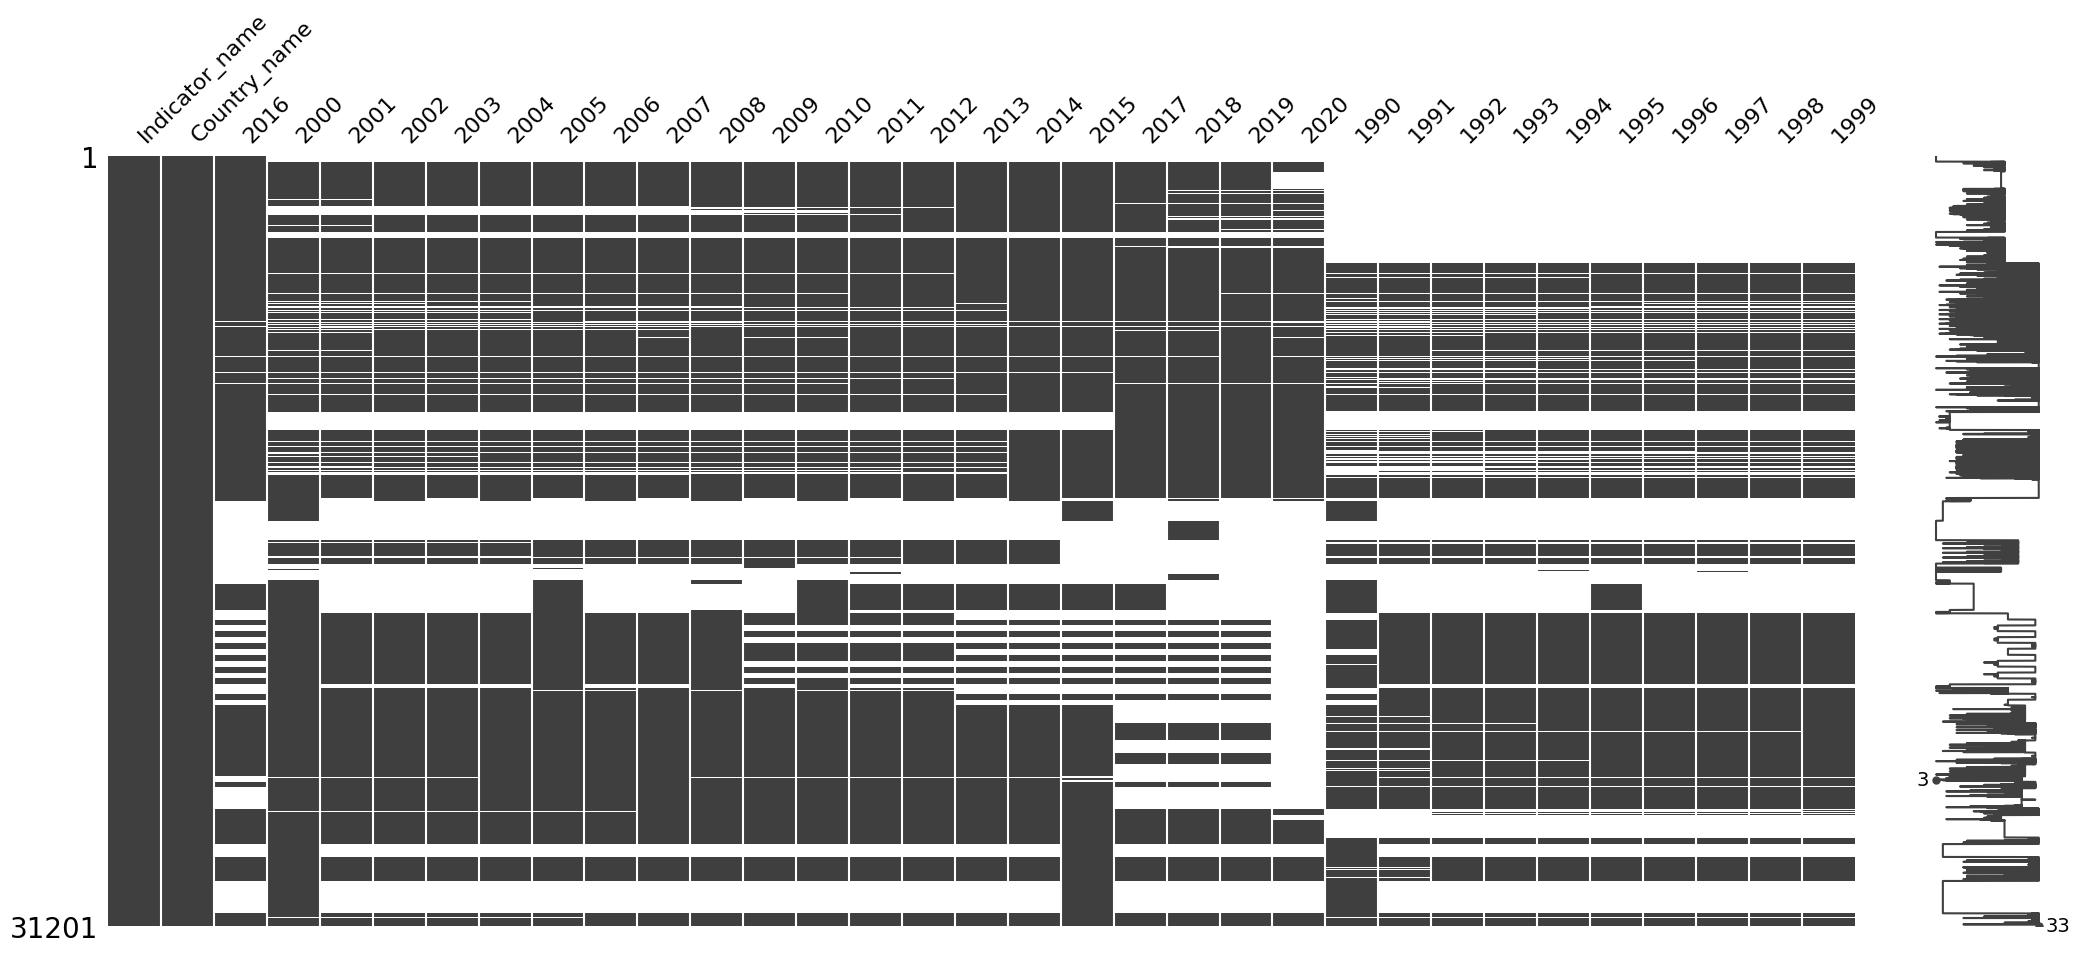

In [181]:
environment_df = create_df(indicators, (1990,2020))
msno.matrix(environment_df)

In [73]:
environment_df.head()

date                                     Indicator_name Country_name   
0     Mortality rate attributed to unsafe water, uns...           1A  \
1     Mortality rate attributed to unsafe water, uns...           1W   
2     Mortality rate attributed to unsafe water, uns...           4E   
3     Mortality rate attributed to unsafe water, uns...           7E   
4     Mortality rate attributed to unsafe water, uns...           8S   

date       2016  2000  2001  2002  2003  2004  2005  2006  ...  1990  1991   
0      7.316462   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN  \
1     11.823676   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
2      2.219411   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
3      0.367145   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
4     17.834964   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   

date  1992  1993  1994  1995  1996  1997  1998  1999  
0      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 33 columns]

In [7]:
environment_df['Indicator_name'].unique()

array(['Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)',
       'People using safely managed sanitation services (% of population)',
       'People using safely managed sanitation services, urban (% of urban population)',
       'People using safely managed sanitation services, rural (% of rural population)',
       'Mortality rate attributed to unintentional poisoning, male (per 100,000 male population)',
       'Mortality rate attributed to unintentional poisoning, female (per 100,000 female population)',
       'Mortality rate attributed to unintentional poisoning (per 100,000 population)',
       'People practicing open defecation (% of population)',
       'People practicing open defecation, urban (% of urban population)',
       'People practicing open defecation, rural (% of rural population)',
       'People with basic handwashing facilities including soap and water (% of population)',
       'People with basic handwash

In [183]:
erased_indicators = ['Adjusted net savings, excluding particulate emission damage (current US$)',
 'Adjusted net savings, including particulate emission damage (current US$)',
 'Adjusted savings: net national savings (current US$)',
 'Adjusted savings: particulate emission damage (current US$)',
 'Adjusted savings: energy depletion (current US$)',
 'Adjusted savings: mineral depletion (current US$)',
 'Adjusted savings: consumption of fixed capital (current US$)',
 'Adjusted savings: net forest depletion (current US$)',
 'Adjusted savings: carbon dioxide damage (current US$)',
 'Adjusted savings: education expenditure (current US$)',
 'Renewable internal freshwater resources, total (billion cubic meters)',
 'Annual freshwater withdrawals, total (billion cubic meters)',
 'Nitrous oxide emissions in energy sector (thousand metric tons of CO2 equivalent)',
 'Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent)',
 'Agricultural methane emissions (thousand metric tons of CO2 equivalent)',
 'CO2 emissions from solid fuel consumption (kt)',
 'CO2 emissions (kg per 2017 PPP $ of GDP)',
 'CO2 emissions (kg per PPP $ of GDP)',
 'CO2 emissions from liquid fuel consumption (kt)',
 'CO2 emissions (kt)',
 'CO2 emissions from gaseous fuel consumption (kt)',
 'Electricity production from renewable sources, excluding hydroelectric (kWh)',
 'Forest area (sq. km)',
 'Urban land area where elevation is below 5 meters (sq. km)',
 'Rural land area where elevation is below 5 meters (sq. km)',
 'Surface area (sq. km)',
 'Land area (sq. km)',
 'Average precipitation in depth (mm per year)'
                    ]

In [74]:
environment_df = environment_df[~environment_df['Indicator_name'].isin(erased_indicators)]

<Axes: >

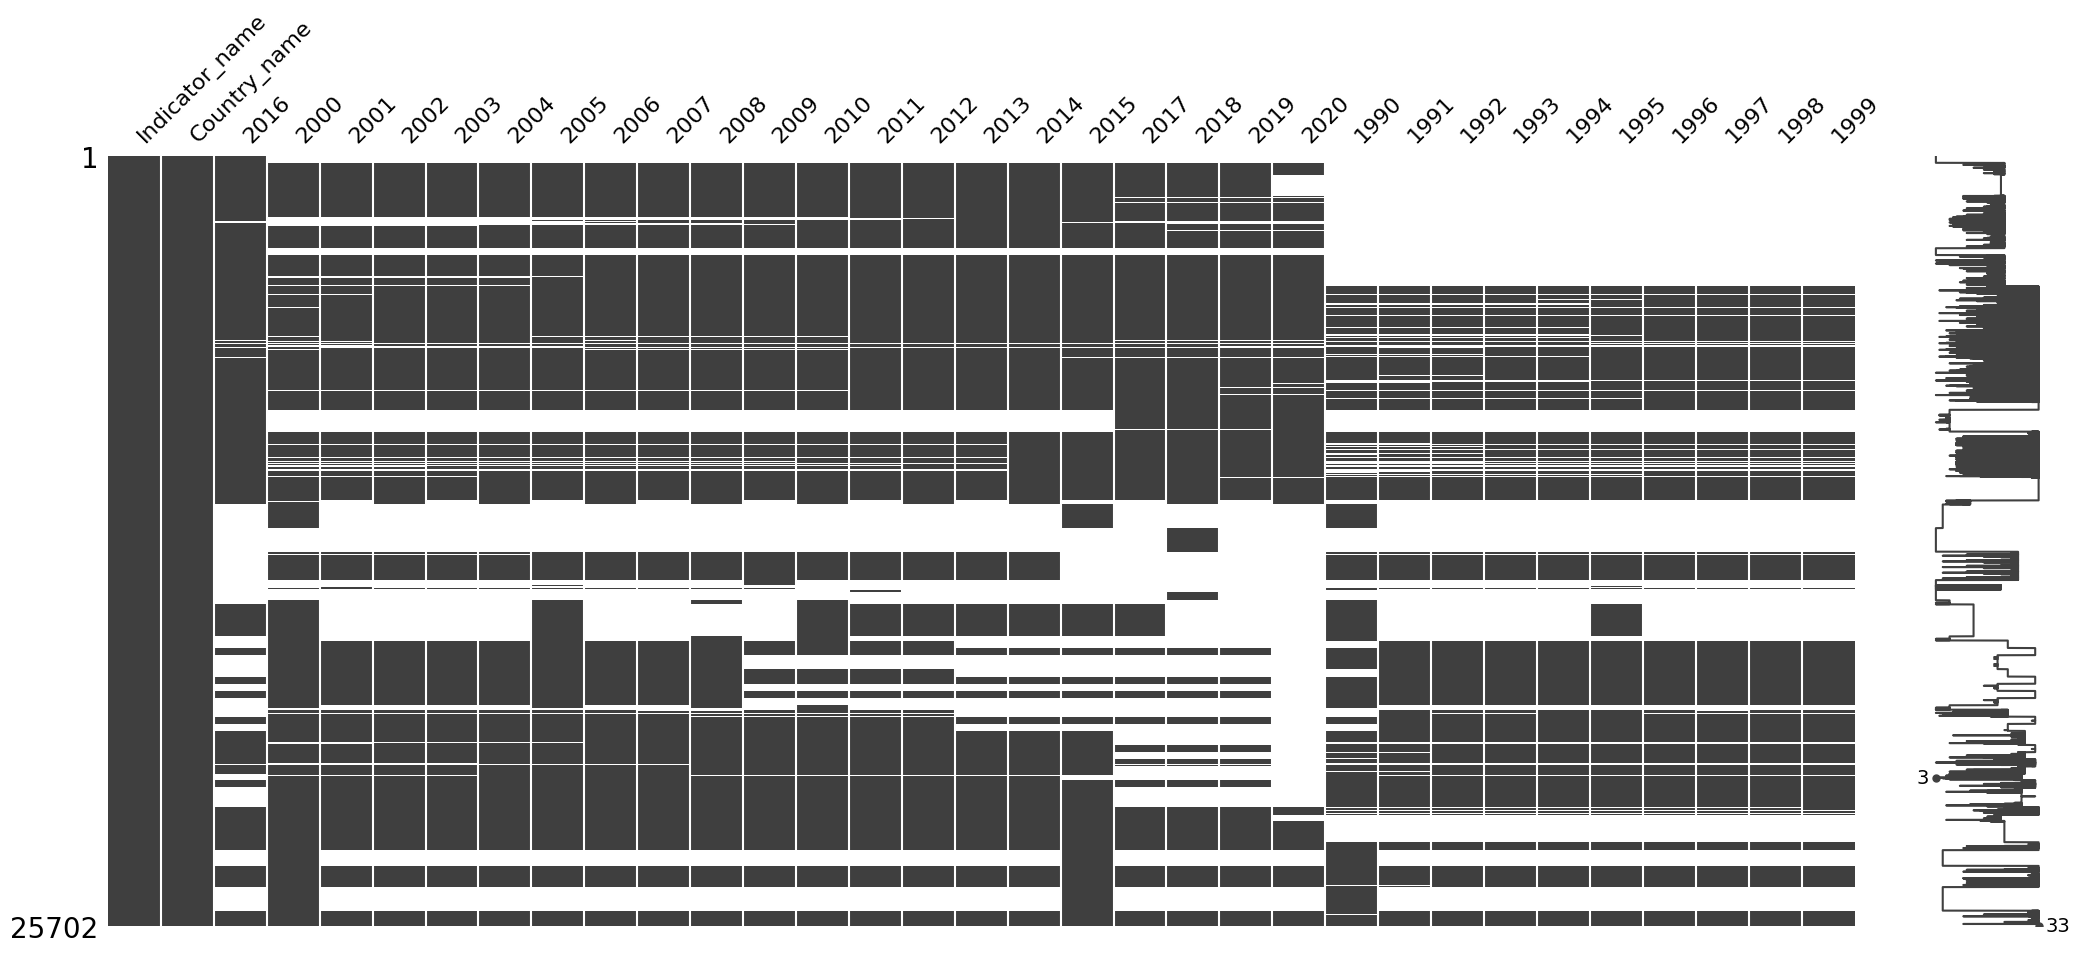

In [75]:
msno.matrix(environment_df)

In [76]:
environment_df.shape

(25702, 33)

In [178]:
def missing_val(df):
    """Drop either indicators or country with too little data to impute."""
    missing_indi = []
    for indi in df['Indicator_name'].unique():
        indi_df = df[df['Indicator_name'] == indi]
        missing_value = (indi_df.isnull().sum().sum() / (indi_df.shape[0]*indi_df.shape[1])*100)
        if missing_value > 50:
            missing_indi.append(indi)
    missing_country = []
    for country in df['Country_name'].unique():
        country_df = df[df['Country_name'] == country]
        missing_value = (country_df.isnull().sum().sum() / (indi_df.shape[0]*country_df.shape[1])*100)
        if missing_value > 50:
            missing_indi.append(country)
    df = df[~df['Indicator_name'].isin(missing_indi)]
    df = df[~df['Indicator_name'].isin(missing_country)]
    print(f'{len(missing_indi)} indicators were dropped and {len(missing_country)} were dropped.')

In [182]:
environment_df = missing_val(environment_df)

34 indicators were dropped and 0 were dropped.


In [82]:
environment_df.to_csv('environment_df.csv', index=False)

In [222]:
environmental_df_impute = pd.read_csv('environment_df_impute.csv')

In [223]:
environmental_df_impute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91280 entries, 0 to 91279
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   2016            91280 non-null  float64
 1   2000            91280 non-null  float64
 2   2001            91280 non-null  float64
 3   2002            91280 non-null  float64
 4   2003            91280 non-null  float64
 5   2004            91280 non-null  float64
 6   2005            91280 non-null  float64
 7   2006            91280 non-null  float64
 8   2007            91280 non-null  float64
 9   2008            91280 non-null  float64
 10  2009            91280 non-null  float64
 11  2010            91280 non-null  float64
 12  2011            91280 non-null  float64
 13  2012            91280 non-null  float64
 14  2013            91280 non-null  float64
 15  2014            91280 non-null  float64
 16  2015            91280 non-null  float64
 17  2017            91280 non-null 

In [224]:
environment_df_long = environmental_df_impute.melt(id_vars=['Country_name', 'Indicator_name','impute_batch'], var_name = 'date')

In [225]:
environment_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829680 entries, 0 to 2829679
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Country_name    object 
 1   Indicator_name  object 
 2   impute_batch    int64  
 3   date            object 
 4   value           float64
dtypes: float64(1), int64(1), object(3)
memory usage: 107.9+ MB


In [226]:
environment_df_long['date'] = pd.to_datetime(environment_df_long['date'], format='%Y')
environment_df_long = environment_df_long.set_index('date')
environment_mean = environment_df_long.groupby(['Indicator_name', 'Country_name', 'impute_batch']).resample('3Y').mean()

In [227]:
environment_mean

value
Indicator_name                                     Country_name impute_batch date                 
Access to clean fuels and technologies for cook... 1A           8            1990-12-31  85.620382
                                                                             1993-12-31  80.046910
                                                                             1996-12-31  77.818067
                                                                             1999-12-31  77.050836
                                                                             2002-12-31  76.952724
...                                                                                            ...
Water productivity, total (constant 2015 US$ GD... ZW           12           2008-12-31   3.323021
                                                                             2011-12-31   3.980511
                                                                             2014-12-31   5.577500
                                                                             2017-12-31   6.026621
                                                                             2020-12-31   5.448524

[999955 rows x 1 columns]

In [228]:
environment_mean = environment_mean.reset_index()
environment_mean

Indicator_name Country_name   
0       Access to clean fuels and technologies for coo...           1A  \
1       Access to clean fuels and technologies for coo...           1A   
2       Access to clean fuels and technologies for coo...           1A   
3       Access to clean fuels and technologies for coo...           1A   
4       Access to clean fuels and technologies for coo...           1A   
...                                                   ...          ...   
999950  Water productivity, total (constant 2015 US$ G...           ZW   
999951  Water productivity, total (constant 2015 US$ G...           ZW   
999952  Water productivity, total (constant 2015 US$ G...           ZW   
999953  Water productivity, total (constant 2015 US$ G...           ZW   
999954  Water productivity, total (constant 2015 US$ G...           ZW   

        impute_batch       date      value  
0                  8 1990-12-31  85.620382  
1                  8 1993-12-31  80.046910  
2                  8 1996-12-31  77.818067  
3                  8 1999-12-31  77.050836  
4                  8 2002-12-31  76.952724  
...              ...        ...        ...  
999950            12 2008-12-31   3.323021  
999951            12 2011-12-31   3.980511  
999952            12 2014-12-31   5.577500  
999953            12 2017-12-31   6.026621  
999954            12 2020-12-31   5.448524  

[999955 rows x 5 columns]

In [229]:

environment_mean['value_zscore'] = environment_mean.groupby(['Indicator_name', 'date', 'impute_batch'])['value'].transform(zscore)

In [230]:
weights = pd.read_csv('weights.csv')
environment_mean = environment_mean.merge(weights, left_on="Indicator_name", right_on="Indicator_name", how="left")

In [231]:
environment_mean.head()

Indicator_name Country_name   
0  Access to clean fuels and technologies for coo...           1A  \
1  Access to clean fuels and technologies for coo...           1A   
2  Access to clean fuels and technologies for coo...           1A   
3  Access to clean fuels and technologies for coo...           1A   
4  Access to clean fuels and technologies for coo...           1A   

   impute_batch       date      value  value_zscore  weights  
0             8 1990-12-31  85.620382      0.730510        1  
1             8 1993-12-31  80.046910      0.612273        1  
2             8 1996-12-31  77.818067      0.553937        1  
3             8 1999-12-31  77.050836      0.517720        1  
4             8 2002-12-31  76.952724      0.513065        1

In [232]:
environment_mean['value_zscore_weight'] = environment_mean['value_zscore']*environment_mean['weights']

In [233]:
sum_df = environment_mean.groupby(['Country_name', 'date','impute_batch'])['value_zscore_weight'].agg('mean')

In [234]:
sum_df = sum_df.reset_index()

In [235]:
sum_df

Country_name       date  impute_batch  value_zscore_weight
0               1A 1990-12-31             8            -0.018911
1               1A 1990-12-31             9            -0.029497
2               1A 1990-12-31            10            -0.032692
3               1A 1990-12-31            11            -0.036159
4               1A 1990-12-31            12            -0.032039
...            ...        ...           ...                  ...
14515           ZW 2020-12-31             8            -0.273686
14516           ZW 2020-12-31             9            -0.275183
14517           ZW 2020-12-31            10            -0.274789
14518           ZW 2020-12-31            11            -0.276131
14519           ZW 2020-12-31            12            -0.276229

[14520 rows x 4 columns]

In [236]:
sum_df['log_value'] = sum_df['value_zscore_weight'].apply(lambda x: ((10/(1+np.exp(-x)))))

In [237]:
mean_df = sum_df.groupby(['Country_name', 'date'])['log_value'].agg(['mean', 'std']).reset_index()

In [238]:
mean_df

Country_name       date      mean       std
0              1A 1990-12-31  4.925357  0.016412
1              1A 1993-12-31  4.880570  0.008160
2              1A 1996-12-31  4.831948  0.009268
3              1A 1999-12-31  4.879486  0.004128
4              1A 2002-12-31  4.855976  0.000571
...           ...        ...       ...       ...
2899           ZW 2008-12-31  4.028484  0.001515
2900           ZW 2011-12-31  4.405752  0.002785
2901           ZW 2014-12-31  4.382033  0.002454
2902           ZW 2017-12-31  4.337648  0.001144
2903           ZW 2020-12-31  4.316301  0.002569

[2904 rows x 4 columns]

In [98]:
(10/(1+np.exp(-0.3)))

5.7444251681165905

In [239]:
test1990 = mean_df[mean_df['date'] == '1990-12-31']
test1990 = test1990.drop(columns=['date'])

In [240]:
test1990

Country_name      mean       std
0              1A  4.925357  0.016412
11             1W  4.055727  0.020003
22             4E  4.548564  0.013198
33             7E  4.877807  0.041086
44             8S  4.411782  0.005138
...           ...       ...       ...
2849           ZJ  5.311928  0.013243
2860           ZM  4.121905  0.015755
2871           ZQ  4.999980  0.007302
2882           ZT  4.043892  0.018917
2893           ZW  4.762745  0.006385

[264 rows x 3 columns]

In [164]:
world_map = gpd.read_file('custom_a2.geojson')

In [165]:
world_map

featurecla  scalerank  labelrank          sovereignt sov_a3   
0    Admin-0 country          1          5          Costa Rica     CR  \
1    Admin-0 country          1          5           Nicaragua     NI   
2    Admin-0 country          1          5  Dominican Republic     DO   
3    Admin-0 country          1          5               Haiti     HT   
4    Admin-0 country          1          6         El Salvador     SV   
..               ...        ...        ...                 ...    ...   
170  Admin-0 country          1          2           Australia     AU   
171  Admin-0 country          1          2         New Zealand     NZ   
172  Admin-0 country          1          3              France     FR   
173  Admin-0 country          1          3     Solomon Islands     SB   
174  Admin-0 country          1          4             Vanuatu     VU   

     adm0_dif  level               type tlc               admin  ...   
0           0      2  Sovereign country   1          Costa Rica  ...  \
1           0      2  Sovereign country   1           Nicaragua  ...   
2           0      2  Sovereign country   1  Dominican Republic  ...   
3           0      2  Sovereign country   1               Haiti  ...   
4           0      2  Sovereign country   1         El Salvador  ...   
..        ...    ...                ...  ..                 ...  ...   
170         1      2            Country   1           Australia  ...   
171         1      2            Country   1         New Zealand  ...   
172         1      2         Dependency   1       New Caledonia  ...   
173         0      2  Sovereign country   1     Solomon Islands  ...   
174         0      2  Sovereign country   1             Vanuatu  ...   

    fclass_id  fclass_pl fclass_gr fclass_it  fclass_nl fclass_se fclass_bd   
0         NaN        NaN       NaN       NaN        NaN       NaN       NaN  \
1         NaN        NaN       NaN       NaN        NaN       NaN       NaN   
2         NaN        NaN       NaN       NaN        NaN       NaN       NaN   
3         NaN        NaN       NaN       NaN        NaN       NaN       NaN   
4         NaN        NaN       NaN       NaN        NaN       NaN       NaN   
..        ...        ...       ...       ...        ...       ...       ...   
170       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
171       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
172       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
173       NaN        NaN       NaN       NaN        NaN       NaN       NaN   
174       NaN        NaN       NaN       NaN        NaN       NaN       NaN   

     fclass_ua     filename                                           geometry  
0          NaN  CRI.geojson  POLYGON ((-82.54620 9.56613, -82.93289 9.47681...  
1          NaN  NIC.geojson  POLYGON ((-83.65561 10.93876, -83.89505 10.726...  
2          NaN  DOM.geojson  POLYGON ((-71.70830 18.04500, -71.68774 18.316...  
3          NaN  HTI.geojson  POLYGON ((-71.71236 19.71446, -71.62487 19.169...  
4          NaN  SLV.geojson  POLYGON ((-89.35333 14.42413, -89.05851 14.340...  
..         ...          ...                                                ...  
170        NaN  AUS.geojson  MULTIPOLYGON (((147.68926 -40.80826, 148.28907...  
171        NaN  NZL.geojson  MULTIPOLYGON (((176.88582 -40.06598, 176.50802...  
172        NaN  NCL.geojson  POLYGON ((165.77999 -21.08000, 166.59999 -21.7...  
173        NaN  SLB.geojson  MULTIPOLYGON (((162.11902 -10.48272, 162.39865...  
174        NaN  VUT.geojson  MULTIPOLYGON (((167.21680 -15.89185, 167.84488...  

[175 rows x 170 columns]

In [156]:
world_map[world_map['sovereignt'] == 'Russia']

featurecla  scalerank  labelrank sovereignt  sov_a3  adm0_dif   
133  Admin-0 country          1          2     Russia  Russia         0  \

     level               type tlc   admin  ... fclass_id  fclass_pl fclass_gr   
133      2  Sovereign country   1  Russia  ...       NaN        NaN       NaN  \

    fclass_it  fclass_nl fclass_se fclass_bd  fclass_ua     filename   
133       NaN        NaN       NaN       NaN        NaN  RUS.geojson  \

                                              geometry  
133  MULTIPOLYGON (((178.72530 71.09880, 180.00000 ...  

[1 rows x 170 columns]

In [161]:
country = ['CU1', 'US1', 'DN1', 'GB1', 'CH1', 'IS1','KA1','CYN','SDS','SOL','SAH', 'FR1', 'FI1', 'KOS','NL1', 'AU1', 'NZ1','Russia']
key = ['ES','US','DK','GB','CN','IL','KZ','CY','SS','SO','EH','FR','FI','XK','NL','AU','NZ','RU']
dic = dict(zip(country, key))

In [152]:
sum_df[sum_df['Country_name'] == 'RU']

Country_name       date  value_zscore_weight  log_value
1914           RU 1990-12-31            -0.168337   4.580149
1915           RU 1993-12-31            -0.135006   4.662996
1916           RU 1996-12-31            -0.123609   4.691370
1917           RU 1999-12-31            -0.137461   4.656887
1918           RU 2002-12-31            -0.139927   4.650753
1919           RU 2005-12-31            -0.106867   4.733087
1920           RU 2008-12-31            -0.051234   4.871944
1921           RU 2011-12-31            -0.039309   4.901741
1922           RU 2014-12-31            -0.016906   4.957735
1923           RU 2017-12-31            -0.086059   4.784985
1924           RU 2020-12-31            -0.099137   4.752360

In [104]:
test1990.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 9 to 2902
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country_name  264 non-null    object 
 1   log_value     264 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.2+ KB


In [241]:
merged_data = world_map.merge(test1990, left_on="sov_a3", right_on="Country_name", how="left")

In [242]:
merged_data

featurecla  scalerank  labelrank          sovereignt sov_a3   
0    Admin-0 country          1          5          Costa Rica     CR  \
1    Admin-0 country          1          5           Nicaragua     NI   
2    Admin-0 country          1          5  Dominican Republic     DO   
3    Admin-0 country          1          5               Haiti     HT   
4    Admin-0 country          1          6         El Salvador     SV   
..               ...        ...        ...                 ...    ...   
170  Admin-0 country          1          2           Australia     AU   
171  Admin-0 country          1          2         New Zealand     NZ   
172  Admin-0 country          1          3              France     FR   
173  Admin-0 country          1          3     Solomon Islands     SB   
174  Admin-0 country          1          4             Vanuatu     VU   

     adm0_dif  level               type tlc               admin  ...   
0           0      2  Sovereign country   1          Costa Rica  ...  \
1           0      2  Sovereign country   1           Nicaragua  ...   
2           0      2  Sovereign country   1  Dominican Republic  ...   
3           0      2  Sovereign country   1               Haiti  ...   
4           0      2  Sovereign country   1         El Salvador  ...   
..        ...    ...                ...  ..                 ...  ...   
170         1      2            Country   1           Australia  ...   
171         1      2            Country   1         New Zealand  ...   
172         1      2         Dependency   1       New Caledonia  ...   
173         0      2  Sovereign country   1     Solomon Islands  ...   
174         0      2  Sovereign country   1             Vanuatu  ...   

    fclass_it  fclass_nl fclass_se fclass_bd  fclass_ua     filename   
0         NaN        NaN       NaN       NaN        NaN  CRI.geojson  \
1         NaN        NaN       NaN       NaN        NaN  NIC.geojson   
2         NaN        NaN       NaN       NaN        NaN  DOM.geojson   
3         NaN        NaN       NaN       NaN        NaN  HTI.geojson   
4         NaN        NaN       NaN       NaN        NaN  SLV.geojson   
..        ...        ...       ...       ...        ...          ...   
170       NaN        NaN       NaN       NaN        NaN  AUS.geojson   
171       NaN        NaN       NaN       NaN        NaN  NZL.geojson   
172       NaN        NaN       NaN       NaN        NaN  NCL.geojson   
173       NaN        NaN       NaN       NaN        NaN  SLB.geojson   
174       NaN        NaN       NaN       NaN        NaN  VUT.geojson   

                                              geometry  Country_name   
0    POLYGON ((-82.54620 9.56613, -82.93289 9.47681...            CR  \
1    POLYGON ((-83.65561 10.93876, -83.89505 10.726...            NI   
2    POLYGON ((-71.70830 18.04500, -71.68774 18.316...            DO   
3    POLYGON ((-71.71236 19.71446, -71.62487 19.169...            HT   
4    POLYGON ((-89.35333 14.42413, -89.05851 14.340...            SV   
..                                                 ...           ...   
170  MULTIPOLYGON (((147.68926 -40.80826, 148.28907...            AU   
171  MULTIPOLYGON (((176.88582 -40.06598, 176.50802...            NZ   
172  POLYGON ((165.77999 -21.08000, 166.59999 -21.7...            FR   
173  MULTIPOLYGON (((162.11902 -10.48272, 162.39865...            SB   
174  MULTIPOLYGON (((167.21680 -15.89185, 167.84488...            VU   

         mean       std  
0    5.931873  0.009728  
1    5.643107  0.006067  
2    5.408355  0.007133  
3    4.716820  0.015722  
4    5.664507  0.006382  
..        ...       ...  
170  5.341512  0.001750  
171  5.755394  0.007849  
172  5.614630  0.032531  
173  5.348493  0.031164  
174  5.248048  0.015899  

[175 rows x 173 columns]

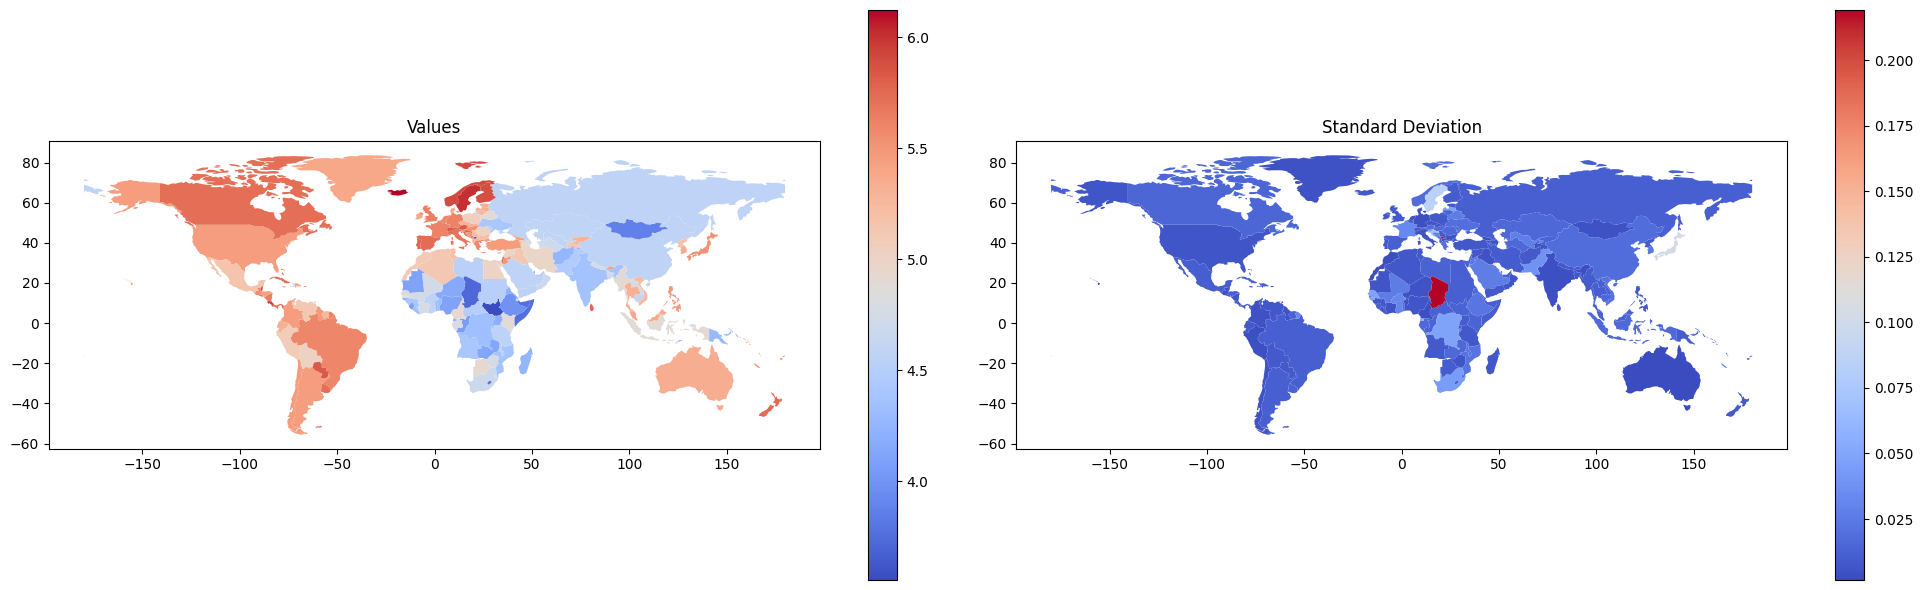

In [246]:
# Create the figure and axes
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

merged_data.plot(column='mean', cmap='coolwarm', legend=True, ax=ax[0])
ax[0].set_title('Values')

merged_data.plot(column='std', cmap='coolwarm', legend=True, ax=ax[1])
ax[1].set_title('Standard Deviation')



# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()